In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import normalized_mutual_info_score
import unicodedata
import seaborn as sns
from nltk import edit_distance

CURRENT_YEAR = datetime.now().year
EARLIEST_PUBLICATION = 868

## Data preparation
Data imputation - filling in missing\
Scaling ranges - removes outliers\
Grouping - group into relevant categories\

Feature selection


In [2]:
# Reading in data from csvs
users = pd.read_csv('BX-Users.csv')
books = pd.read_csv('BX-Books.csv')
ratings = pd.read_csv('BX-Ratings.csv')

#### Preprocess User locations (City, State, Country)
Methods used:\
Cleaning data, removing spaces and punctuation, convert to all caps\
Standardising location names to donwloaded location database through fuzzy matching\
Imputation to fill in missing or wrong data using KNN imputation\
Ecnoding locations to integer values for imputation\
Analysis of IM between datapoints and evaluating viability of imputing with KNN\
\
Final Output: (fully processed and imputed location data)\
dec_country\
dec_state\
dec_city



##### Fuzzy matching

In [88]:
#Standardising comparison CSVs 

# editing the countries and states csv to be all upper and contain no spaces and unicode NFKD
countries = pd.read_csv("countries.csv")
countries['name'] = countries["name"].str.replace(r'[\W]', '', regex=True)
countries['name'] = countries['name'].str.upper().apply(lambda x: unicodedata.normalize("NFKD", x))
countries['name'].to_csv("countryonly.csv", index=False, )

# same as above but for states 
states = pd.read_csv('states.csv')
states["name"] = states["name"].str.replace(r'[\W]', '', regex=True).str.upper().apply(lambda x: unicodedata.normalize("NFKD", x))
states["country_name"] = states["country_name"].str.replace(r'[\W]', '', regex=True).str.upper().apply(lambda x: unicodedata.normalize("NFKD", x))
states[["name", "country_name"]].to_csv("states_wcountry.csv", index=False)


# for cities
cities = pd.read_csv('cities.csv').astype(str)
#cities = cities.replace(r'[\W]', '', regex=True)
cities['name'] = cities['name'].str.replace(r'[\W]', '', regex=True).str.upper().apply(lambda x: unicodedata.normalize("NFKD", x))
cities["country_name"] = cities["country_name"].str.replace(r'[\W]', '', regex=True).str.upper().apply(lambda x: unicodedata.normalize("NFKD", x))
cities[["name", "country_name"]].to_csv("cities_wcountry.csv", index=False)

In [4]:
# LOAD IN STUFF 
# make city, state and country unicode normalise, no spaces or punctuation and all lower
users["User-City"] = users["User-City"].str.replace(r'[\W]', '', regex=True).str.upper().dropna().apply(lambda x: unicodedata.normalize("NFKD", x))
users["User-State"] = users["User-State"].str.replace(r'[\W]', '', regex=True).str.upper().dropna().apply(lambda x: unicodedata.normalize("NFKD", x))
users["User-Country"] = users["User-Country"].str.replace(r'[\W]', '', regex=True).str.upper().dropna().apply(lambda x: unicodedata.normalize("NFKD", x))

# LOADING IN THE STANDARDS
cities = pd.read_csv("cities_wcountry.csv")
states = pd.read_csv('states.csv')
countries = pd.read_csv("countryonly.csv")


In [5]:
# FUNC: FUZZY MATCH ALGORITHM
# fuzzy matching implementation, uses similarity function with edit distance

def normalised_edit_sim(s1, s2):
    """
    A function which computes the Levenshtein edit distance
    """
    #print(s1, s2)
    return 1 - edit_distance(s1, s2) / max(len(s1), len(s2))

# if string is matched, return element from cmparr, otherwise returns np.nan
def fuzzy_match(string, cmparr, threshold=0.6):
    for element in cmparr:
        if normalised_edit_sim(string, element) >= threshold:
            return element
    return np.nan

In [6]:
# FUNC: "SMART" FUZZY MATCHING 
# matches the top however many unmatched
def smart_match(series, std_series, unmatched, min_occ, max_matches=100, thresh=0.6):
    # sort unmatched with top occurences first
    unmatched = unmatched.sort_values(ascending=False)

    #if there are too many to match, just match max_matches
    to_match = min(len(unmatched[unmatched > min_occ].index), max_matches)
    print(f"Number of matches to make: {to_match}")

    matched = 0

    for i in range(to_match):
        result = fuzzy_match(unmatched.index[i], std_series['name'], threshold=thresh)
        if (result is not np.nan):
            matched += 1

        print(unmatched.index[i], result, f"progress: {matched}")
        series = series.replace(unmatched.index[i], result)

    return series


In [7]:
# FUNC: FIND UNMATCHED, print info

def find_unmatched(df, standard, col):
    return df[~df[col].isin(standard['name'])].dropna().groupby(col)[col].count().sort_values(ascending=False)

def print_info(series, unmatched):
    print(f"Current unmatched series \n{unmatched}\n")
    print(f"Len of unmatched (exclude nan) {len(unmatched)}")
    print(f"Number of unmatched occurences {unmatched.sum()}")

    print(f"Total nan                      {series.isna().sum()}")

In [8]:
# FUNC: change remain unmatched into np.nan
def make_na(series, unmatched):
    for el in unmatched.index:
        series = series.replace(el, np.nan)
    return series

In [9]:
# FUZZY MATCHING COUNTRIES
#print_info(users['User-Country'], unmatched)

# manual corrections
users["User-Country"] = users["User-Country"].replace("USA", "UNITEDSTATES")

# standard we are comparing to 
countries = pd.read_csv("countryonly.csv")

# do fuzzy matching
unmatched = find_unmatched(users, countries, "User-Country")
users["User-Country"] = smart_match(users['User-Country'], countries, unmatched, 0, thresh=0.6)


# show matching info
print_info(users['User-Country'], unmatched)

# finding remaining unmatched
unmatched = find_unmatched(users, countries, "User-Country")
users["User-Country"] = make_na(users["User-Country"], unmatched)
unmatched = find_unmatched(users, countries, "User-Country")

# show matching info
print_info(users['User-Country'], unmatched)

Number of matches to make: 27
HONGKONG HONGKONGSAR progress: 1
ENGLAND nan progress: 1
YUGOSLAVIA nan progress: 1
CATALUNYA nan progress: 1
EUSKALHERRIA nan progress: 1
BAHAMAS THEBAHAMAS progress: 2
AMERICA nan progress: 2
BURMA nan progress: 2
CATALONIA nan progress: 2
DEUTSCHLAND nan progress: 2
ESPAÑA nan progress: 2
EVERYWHEREANDANYWHERE nan progress: 2
FARAWAY PARAGUAY progress: 3
ITALIA ITALY progress: 4
MACEDONIA NORTHMACEDONIA progress: 5
NZ nan progress: 5
QUIT nan progress: 5
PENDER nan progress: 5
PHILLIPINES PHILIPPINES progress: 6
UK nan progress: 6
UNITEDSTATE UNITEDSTATES progress: 7
UNIVERSE nan progress: 7
URUGUA URUGUAY progress: 8
WALES nan progress: 8
YSA nan progress: 8
ORENSE nan progress: 8
LAFRANCE FRANCE progress: 9
Current unmatched series 
User-Country
HONGKONG                 8
ENGLAND                  4
YUGOSLAVIA               3
CATALUNYA                2
EUSKALHERRIA             2
BAHAMAS                  2
ORENSE                   1
YSA                

In [10]:
## FUZZY MATCHING CITIES

# manual matches
# NONE

# import standard cities
cities = pd.read_csv("cities_wcountry.csv")

# do fuzzy matching
unmatched = find_unmatched(users, cities, "User-City")
users["User-City"] = smart_match(users['User-City'], cities, unmatched, 5, thresh=0.7)


# show matching info
print_info(users['User-City'], unmatched) #this is before updating unmatched, so still contains old unmatched that has been matched

# finding remaining unmatched
unmatched = find_unmatched(users, cities, "User-City")
users["User-City"] = make_na(users["User-City"], unmatched)
unmatched = find_unmatched(users, cities, "User-City")

# show matching info
print_info(users['User-City'], unmatched)




Number of matches to make: 23
NEWYORK NEWPORT progress: 1
MONTREAL MOUNTPEARL progress: 2
LISBOA LISBON progress: 3
MÜNCHEN MÜNCHBERG progress: 4
STPAUL STPAULI progress: 5
WIEN WIES progress: 6
MILANO MIDLAND progress: 7
STCHARLES SAINTCHARLES progress: 8
FRANKFURT FRANKFORT progress: 9
PLOIESTI PLOIEŞTI progress: 10
NYC nan progress: 10
ACORUÑA CORUNNA progress: 11
ISTANBUL nan progress: 11
DUESSELDORF DÜSSELDORF progress: 12
VITORIA VICTORIA progress: 13
ZURICH AURICH progress: 14
GENOVA GÉNOVA progress: 15
HONGKONG HONGTANG progress: 16
BRICK BERWICK progress: 17
FIRENZE FORENZA progress: 18
SAOPAULO SANPABLO progress: 19
ALLSTON GALSTON progress: 20
MILILANI MAILANI progress: 21
Current unmatched series 
User-City
NEWYORK                 155
MONTREAL                 74
LISBOA                   58
MÜNCHEN                 46
STPAUL                   42
                       ... 
HAMBURGRAHLSTEDT          1
HAMBURGHARBURG            1
HALFWAYDOWNTHESTAIRS      1
HAINESFALLS  

In [11]:
# FUZZY MATCHING STATES

# manual changes
users["User-State"] = users["User-State"].replace("", np.nan)
users["User-State"] = users["User-State"].replace("NA", np.nan)
users["User-State"] = users["User-State"].replace("DC", "WASHINGTON")

#users["User-State"] = users["User-State"].replace("na", np.nan)

# importing standard csv for states
states = pd.read_csv('states_wcountry.csv')

# this the the states that haven't been matched yet
unmatched = find_unmatched(users, states, "User-State")
users['User-State'] = smart_match(users["User-State"], states, unmatched, 2, max_matches=200)

# show matching info
print_info(users['User-State'], unmatched)

# finding remaining unmatched
unmatched = find_unmatched(users, states, "User-State")
users["User-State"] = make_na(users["User-State"], unmatched)
unmatched = find_unmatched(users, states, "User-State")

# show matching info
print_info(users['User-State'], unmatched)


Number of matches to make: 104
NORDRHEINWESTFALEN NORTHRHINEWESTPHALIA progress: 1
BAYERN BERN progress: 2
BADENWUERTTEMBERG BADENWÜRTTEMBERG progress: 3
HESSEN HESSE progress: 4
NIEDERSACHSEN nan progress: 4
CATALUNYA SATAKUNTA progress: 5
ILEDEFRANCE HAUTSDEFRANCE progress: 6
LOMBARDIA LOMBARDY progress: 7
RHEINLANDPFALZ nan progress: 7
LISBOA LISBON progress: 8
SACHSEN nan progress: 8
WIEN SIENA progress: 9
ZUIDHOLLAND SOUTHHOLLAND progress: 10
NOORDHOLLAND NORTHHOLLAND progress: 11
CANTERBURY CANTERBURYREGION progress: 12
TOSCANA TASMANIA progress: 13
OTAGO BAGO progress: 14
RHÔNEALPES CHONTALES progress: 15
PIEMONTE PIEDMONT progress: 16
THUERINGEN THURINGIA progress: 17
NEWFOUNDLAND nan progress: 17
ARAGÓN BAYAMÓN progress: 18
CATALUÑA SATAKUNTA progress: 19
SACHSENANHALT SAXONYANHALT progress: 20
GALICIA PALENCIA progress: 21
NRW nan progress: 21
LONDON ONDO progress: 22
SINGAPORE nan progress: 22
YUKONTERRITORY nan progress: 22
VIZCAYA nan progress: 22
PRAHOVA nan progress

##### Encoding location strings with number (for imputation)

In [12]:
# FUNC: general function that makes set from user locations, then will encode them a length, return encoded series, encodes nan as -1
def encoding_dict(series):
    keys = set(series)
    encoding = dict()

    if np.nan in keys:
        keys.remove(np.nan)
        encoding[np.nan] = -1
    
    i = 0
    while keys:
        encoding[keys.pop()] = i
        i += 1
        
    return encoding

def encode(series):
    encoding = encoding_dict(series)
    return series.map(encoding), encoding

def decode(series, encoding):
    decoding = dict((v,k) for k,v in encoding.items())
    #print(decoding)
    return series.astype(int).map(decoding)


In [13]:
# encodes location
enc_country, e1 = encode(users['User-Country'])
enc_state, e2 = encode(users['User-State'])
enc_city, e3 = encode(users['User-City'])

In [14]:
# make -1 to np.nan for imputing
enc_country_wnan = enc_country.replace(-1, np.nan)
enc_state_wnan = enc_state.replace(-1, np.nan)
enc_city_wnan = enc_city.replace(-1, np.nan)


In [15]:
# prepare for imputing
# zip and make into list
to_impute = list(pd.Series(zip(enc_city_wnan, enc_state_wnan, enc_country_wnan)).apply(list))

In [16]:
len(to_impute)

48299

In [17]:
# KNN for imputing locations that are np.nan

from sklearn.impute import KNNImputer

imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")
imputed = imputer.fit_transform(to_impute)


In [18]:
df = pd.DataFrame(imputed, columns=["city", "state", "country"])

In [19]:
# THESE CONTAIN THE FINAL IMPUTED LOCATIONS

dec_country = decode(df["country"].astype(int), e1)
dec_state = decode(df["state"].astype(int), e2)
dec_city = decode(df["city"].astype(int), e3)

In [20]:
# PUTTING FINAL IMPUTATIONS BACK INTO USERS DATAFRAME
users["User-Country"] = dec_country
users["User-State"] = dec_state
users["User-City"] = dec_city

In [21]:
# testing that all is matched (returns 0 if all matched)
print(dec_city.isna().sum())
print(dec_state.isna().sum())
print(dec_country.isna().sum())

0
0
0


In [22]:
# correlation between state and city before imputing np.nan
normalized_mutual_info_score(enc_state,
                             enc_city,
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.860403121336627

In [23]:
# Correlation after imputing
normalized_mutual_info_score(dec_state,
                             dec_city,
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.9116991163971048

In [24]:
# nonlinear correlation
FEATURES = ["country", 'state', 'city']
df[FEATURES].corr(method='pearson')

,country,state,city
country,1.000000,-0.134537,-0.018597
state,-0.134537,1.000000,-0.002665
city,-0.018597,-0.002665,1.000000


#### Preprocess Book title, author, publisher, Year of publication (YOP)\
YOP has missing data which is imputed using book author with KNN


In [25]:
books['Book-Title'] = books['Book-Title'].str.upper()
books['Book-Title'] = books['Book-Title'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

books['Book-Author'] = books['Book-Author'].str.upper()  # Convert to lowercase
books['Book-Author'] = books['Book-Author'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

books['Book-Publisher'] = books['Book-Publisher'].str.upper()
books['Book-Publisher'] = books['Book-Publisher'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)




##### Imputing missing data for publication year (YOP)

In [26]:
# Checking for publication years that are impossible (less than one or in the future)
books['Year-Of-Publication'] = books['Year-Of-Publication'].apply(lambda x: -1 if x < EARLIEST_PUBLICATION or x > CURRENT_YEAR else x)

# Fill NaN as -1
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(-1)

In [27]:
# testing book publisher against YOP (around 0.23)
normalized_mutual_info_score(books["Book-Publisher"],
                             books['Year-Of-Publication'],
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')


0.2311571895270557

In [28]:
# testing book author against YOP (around 0.533, choose this)
normalized_mutual_info_score(books["Book-Author"],
                             books['Year-Of-Publication'],
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.5331443020723939

In [29]:
# We choose the book author to impute missing YOP
encoded_author, enc = encode(books["Book-Author"])

books['Year-Of-Publication'] = books['Year-Of-Publication'].replace(-1, np.nan)

to_imputate_YOP = list(pd.Series(zip(books["Year-Of-Publication"], encoded_author)).apply(list))

In [30]:
books.isna().sum()

ISBN                     0
Book-Title               0
Book-Author              0
Year-Of-Publication    317
Book-Publisher           0
dtype: int64

In [31]:
# length to impute
len(to_imputate_YOP)

18185

In [32]:
# imputing using knn
imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")
imputed = pd.DataFrame(imputer.fit_transform(to_imputate_YOP), columns=["Year-Of-Publication", "Book-Author"])
books["Year-Of-Publication"] = imputed["Year-Of-Publication"].round().astype(int)
books["Year-Of-Publication"]

0        2001
1        1999
2        1991
3        1999
4        1994
         ... 
18180    2001
18181    1997
18182    2003
18183    1997
18184    1992
Name: Year-Of-Publication, Length: 18185, dtype: int64

#### Preprocess User Age
Methods used:\
Removed all punctuation and letters, made all numbers\
Scaling: valid age range [0,116]\
Comparing correlations to find best predicter of age (Book title)


In [33]:
# ryan - Cleaning the User ages column
users['User-Age'].str.strip()  # Removes leading and trailing whitespaces
users['User-Age'] = users['User-Age'].apply(lambda x: re.sub(r'\D', '', str(x))) # substituting every non-digit char to empty string

users['User-Age'] = pd.to_numeric(users['User-Age'], errors='coerce') # make any leftover non-numeric values into NaN
users['User-Age'] = users['User-Age'].fillna(-1).astype(int) # make NaNs -1 and others integers

In [34]:
# book rating corresponding to each user
book_rating = users["User-ID"].map(pd.Series(ratings["Book-Rating"].values, index=ratings["User-ID"]).to_dict())

In [35]:
normalized_mutual_info_score(book_rating,
                             users["User-Age"],
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.0061731350800652285

In [36]:
#isbn corresponding to each user row
isbn = users["User-ID"].map(pd.Series(ratings["ISBN"].values, index=ratings["User-ID"]).to_dict())

In [37]:
# correlation for isbn and age
normalized_mutual_info_score(isbn,
                             users["User-Age"],
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.589517125139497

In [38]:
#author to each user
author = isbn.map(pd.Series(books["Book-Author"].values, index=books["ISBN"]).to_dict())

In [39]:
# correlation of author to age
normalized_mutual_info_score(author,
                             users["User-Age"],
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.31981899820684645

In [40]:
encode_city, enc = encode(dec_city)

In [41]:
# encoding isbn for imputing age
#isbn = isbn.str.replace(r'[\D]', '', regex=True)
encode_isbn, enc = encode(isbn)

In [42]:


# Peter - make outliers -1, valid range is [0, 116]
# make -1 back to np.nan for imputation below
users.loc[(users["User-Age"] < 0) | (users["User-Age"] > 116), "User-Age"] = -1

#print(users["User-Age"].head(50))

# Impute using k-NN
# Replace invalid points with np.nan for the sklearn KNN imputer to work
users["User-Age"] = users["User-Age"].replace(-1, np.nan)

#avg_ratings_to_user_age = pd.Series(ratings.groupby("User-ID")["Book-Rating"].mean())
#avg_ratings_df = avg_ratings_to_user_age.reset_index()

# convert the columns to row things for knn imputer
#to_imputate_age = list(pd.Series(zip(users["User-Age"], avg_ratings_df["Book-Rating"], encode_city)).apply(list))
to_imputate_age = list(pd.Series(zip(users["User-Age"], encode_isbn)).apply(list))


In [43]:
len(to_imputate_age)

48299

In [44]:
# imputing using knn
imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")
#imputed = pd.DataFrame(imputer.fit_transform(to_imputate_age), columns=["User-Age", "Book-Rating", "city"])
imputed = pd.DataFrame(imputer.fit_transform(to_imputate_age), columns=["User-Age", "ISBN"])

In [45]:
users['User-Age'] = imputed['User-Age'].round().astype(int)
users['User-Age']

0        35
1        50
2        30
3        37
4        14
         ..
48294    23
48295    23
48296    33
48297    32
48298    41
Name: User-Age, Length: 48299, dtype: int64

In [46]:
print("AGE score =",normalized_mutual_info_score(users["User-Age"], book_rating, average_method='min'))

AGE score = 0.005350386850414405


#### Feature selection
Method:
Mutual information between feature and rating

In [47]:
new_users = users.set_index("User-ID")

In [48]:
new_users

,User-City,User-State,User-Country,User-Age
User-ID,,,,
8,TIMMINS,ONTARIO,CANADA,35
9,GERMANTOWN,TENNESSEE,UNITEDSTATES,50
16,ALBUQUERQUE,NEWMEXICO,UNITEDSTATES,30
17,CHESAPEAKE,VIRGINIA,UNITEDSTATES,37
19,WESTON,WASHINGTON,UNITEDSTATES,14
...,...,...,...,...
278846,TORONTO,ONTARIO,CANADA,23
278849,GEORGETOWN,ONTARIO,CANADA,23
278851,DALLAS,TEXAS,UNITEDSTATES,33


In [49]:
age_bins = [0, 19, 25, 40, 60, 120]
age_labels = ["Young", "Young_Adult", "Adult", "Middle_Aged", "Old"]

In [50]:
# for mapping cols of users to ratings
user_dict = new_users.to_dict()

usr_city = ratings["User-ID"].map(user_dict["User-City"])
usr_state = ratings["User-ID"].map(user_dict["User-State"])
usr_ctry = ratings["User-ID"].map(user_dict["User-Country"])
usr_age = ratings["User-ID"].map(user_dict["User-Age"])
binned_usr_age = pd.cut(usr_age, bins=age_bins, labels=age_labels, include_lowest=True)
usr_id = ratings["User-ID"] #quite 

usr_cols = [usr_city, usr_state, usr_ctry, usr_age, binned_usr_age, usr_id]

In [51]:
binned_usr_age

0         Middle_Aged
1               Young
2               Adult
3         Young_Adult
4               Adult
             ...     
204159          Adult
204160          Adult
204161          Adult
204162          Adult
204163          Adult
Name: User-ID, Length: 204164, dtype: category
Categories (5, object): ['Young' < 'Young_Adult' < 'Adult' < 'Middle_Aged' < 'Old']

In [52]:
# comparing cols of Users to ratings
for col in usr_cols:
    print(normalized_mutual_info_score(col, ratings["Book-Rating"], average_method='min'))

0.11247181967095064
0.014947789476197714
0.006605477719809383
0.0047351275919494925
0.0011162087713957867
0.4175322224571087


In [53]:
# mapping for cols of BOOKS to ratings
bk_dict = books.set_index("ISBN").to_dict()

bk_isbn = ratings["ISBN"]
bk_title = ratings["ISBN"].map(bk_dict['Book-Title'])
bk_author = ratings["ISBN"].map(bk_dict['Book-Author'])
bk_yop = ratings["ISBN"].map(bk_dict['Year-Of-Publication'])
bk_publisher = ratings["ISBN"].map(bk_dict['Book-Publisher'])

bk_cols = [bk_isbn, bk_title, bk_author, bk_yop, bk_publisher]

In [54]:
# comparing correlation to ratings
for col in bk_cols:
    print(normalized_mutual_info_score(col, ratings["Book-Rating"], average_method='min'))

0.20645111097739202
0.18487315363403808
0.08964562855032683
0.0036007227653762214
0.026060282398355245


## Data modelling
#### **Unsupervised**
  K-Means clustering\
  Agglomerative clustering\
  (both in W7 workshop I think)\
  Correlation\
  Mutual Information

#### **Supervised**
  Decision trees\
  Linear regression\
  K Nearest Neighbours


Principle Component Analysis - could use to reduce dimensionality of data



#### Model justification - Lack of linearality in data

In [55]:
# Encode data so we can apply pearson correlation
enc_usr_city, enc1 = encode(usr_city)
enc_bk_author, enc2 = encode(bk_author)
enc_bk_isbn, enc3 = encode(bk_isbn)
enc_bk_title, enc4 = encode(bk_title)
enc_bk_publisher, enc5 = encode(bk_publisher)

names=["City", "Author", "ISBN", "Title", "Publisher", "Age", "Ratings"]
features = [enc_usr_city, enc_bk_author, enc_bk_isbn, enc_bk_title, enc_bk_publisher, usr_age, ratings["Book-Rating"]]
# usr_cols
usr_rating_dict = {names[i]:features[i] for i in range(len(names))}

In [56]:
df = pd.DataFrame(data=usr_rating_dict)
df.corr(method='pearson')

,City,Author,ISBN,Title,Publisher,Age,Ratings
City,1.000000,-0.007184,-0.000395,-0.004675,-0.010984,0.033903,0.010844
Author,-0.007184,1.000000,-0.002181,0.021905,-0.046997,0.008014,0.013641
ISBN,-0.000395,-0.002181,1.000000,-0.006090,-0.017097,0.007302,-0.000884
Title,-0.004675,0.021905,-0.006090,1.000000,0.007565,-0.005943,0.004094
Publisher,-0.010984,-0.046997,-0.017097,0.007565,1.000000,-0.048287,0.018386
Age,0.033903,0.008014,0.007302,-0.005943,-0.048287,1.000000,-0.014037
Ratings,0.010844,0.013641,-0.000884,0.004094,0.018386,-0.014037,1.000000


##### K Nearest Neighbours
We found, usr city, book isbn and book author were quite hgihly correlated to usr rating

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score


In [58]:
# training model return knn model
def train_knn(X_train, y_train, k):
    # Create and fit knn with k=3
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit to the train dataset
    return knn.fit(X_train, y_train)


In [59]:
## apply categories to y class labels Low, Medium, High [0,3],[4,6],[7,10]
# GROUPING DATA
def categorise(num):
    if num <= 3:
        return "Low"
    elif 4 <= num <= 6:
        return "Medium"
    else:
        return "High"



In [60]:
#Baseline accuracy, with assumption that our model just predicts high for everything
def get_baseline(model, X_test, y_test):
    y_pred = model.predict(X_test)
    highs = pd.Series(y_pred).value_counts()
    total = len(y_pred)
    return highs/total

# looking at high we see that it is much higher than our own, this suggests we may have undergrouped, and encapsulated too much of the output in a single grouping
#get_baseline(y_pred)

In [61]:
# Evaluate model
def eval_model(model, X_test, y_test):

    y_pred = model.predict(X_test)

    # getting metrics
    recall = recall_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred,average='weighted')
    accuracy = model.score(X_test, y_test)

    df = pd.Series([recall, prec, f1, accuracy], index=["Recall", "Precision", "F1", "Accuracy"])
    return df


In [62]:
# Show and returns confusion matrix
def make_show_CM(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, # test data
                      y_pred, # predictions
                      labels=labels # class labels from the knn model
                     )

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, # pass through the created confusion matrix
                                display_labels=labels # class labels from the knn model 
                                )

    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()
    return cm

10 Fold Cross validation Code

In [63]:
# gives a less biased assessment of model accuracy, returns mean accuracy
def k_cross_validate(model, Xdata, ydata, kfolds=10):
    k_folds = KFold(n_splits = kfolds)


    scores = cross_val_score(model, Xdata, ydata, cv = k_folds)

    return scores.mean()

    # print("Cross Validation Scores: ", scores)
    # print("Average CV Score: ", scores.mean())
    # print("Number of CV Scores used in Average: ", len(scores))

In [64]:
# encoding data
enc_usr_city, enc1 = encode(usr_city)
enc_bk_author, enc2 = encode(bk_author)
enc_bk_isbn, enc3 = encode(bk_isbn)
enc_bk_title, enc4 = encode(bk_title)
enc_bk_publisher, enc5 = encode(bk_publisher)

data = pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher})

Xdata = data
ydata_grouped = ratings["Book-Rating"].apply(categorise)
ydata = ratings["Book-Rating"]

In [65]:
# split data into training and testing

split = 180000 # len is 204164

X_train = Xdata[:split]
y_train = ydata[:split]
y_train_grouped = ydata_grouped[:split]

X_test = Xdata[split:]
y_test = ydata[split:]
y_test_grouped = ydata_grouped[split:]


In [66]:
# ISSUES - not balanced,can plot to show
usr_age.value_counts().sort_values(ascending=False)

34     10601
33      8543
29      7838
30      7817
32      7395
       ...  
99         3
6          2
108        1
96         1
94         1
Name: User-ID, Length: 98, dtype: int64

##### 10 fold cross validation demonstration

In [67]:
# demonstration of k fold cv
model = train_knn(X_train, y_train, 7)
k_cross_validate(model, Xdata, ydata)


0.19918301786474576

##### Analysis on feature selection

In [68]:
# Changing Xdata to the final 4 that we said were best
Xdata = pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher})

In [69]:
# testing different number of features order: max correlation to min
features_acc = []
features_prec = []

data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher}

for n in range(1, len(data)+1):
    data = pd.DataFrame(data=data)
    Xdata = data.iloc[:, :n]

    print(f"Current number of features: {n}\n Feature: {list(data.columns[:n])}")
    model = train_knn(X_train, y_train, 7)
    features_acc.append(k_cross_validate(model, Xdata, ydata))
    features_prec.append(eval_model(model, X_test, y_test)["Precision"])

Current number of features: 1
 Feature: ['Book-ISBN']
Current number of features: 2
 Feature: ['Book-ISBN', 'Book-Title']
Current number of features: 3
 Feature: ['Book-ISBN', 'Book-Title', 'User-City']
Current number of features: 4
 Feature: ['Book-ISBN', 'Book-Title', 'User-City', 'Book-Author']
Current number of features: 5
 Feature: ['Book-ISBN', 'Book-Title', 'User-City', 'Book-Author', 'Book-Publisher']


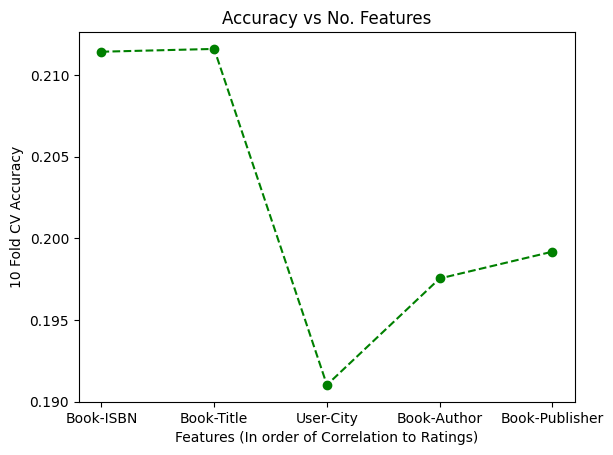

In [70]:
# Plotting model accuracy vs features
plt.plot(data.columns, features_acc, linestyle='--', marker='o', color="g")
#plt.plot(data.columns, features_prec, linestyle='--', marker='o', color="b")
plt.title("Accuracy vs No. Features")
plt.xlabel("Features (In order of Correlation to Ratings)")
plt.ylabel("10 Fold CV Accuracy")
plt.show()

In [71]:
# testing different number of features changed order so that User City is at the end
features_acc = []
features_prec = []

data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-City": enc_usr_city }

for n in range(1, len(data)+1):
    data = pd.DataFrame(data=data)
    Xdata = data.iloc[:, :n]

    print(f"Current number of features: {n}\n Feature: {list(data.columns[:n])}")
    model = train_knn(X_train, y_train, 7)
    features_acc.append(k_cross_validate(model, Xdata, ydata))
    features_prec.append(eval_model(model, X_test, y_test)["Precision"])



Current number of features: 1
 Feature: ['Book-ISBN']
Current number of features: 2
 Feature: ['Book-ISBN', 'Book-Title']
Current number of features: 3
 Feature: ['Book-ISBN', 'Book-Title', 'Book-Author']
Current number of features: 4
 Feature: ['Book-ISBN', 'Book-Title', 'Book-Author', 'Book-Publisher']
Current number of features: 5
 Feature: ['Book-ISBN', 'Book-Title', 'Book-Author', 'Book-Publisher', 'User-City']


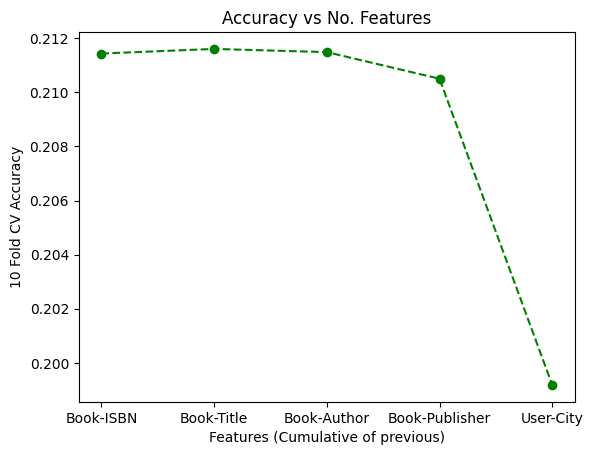

In [72]:
# Plotting model accuracy vs features
plt.plot(data.columns, features_acc, linestyle='--', marker='o', color="g")
#plt.plot(data.columns, features_prec, linestyle='--', marker='o', color="b")
plt.title("Accuracy vs No. Features")
plt.xlabel("Features (Cumulative of previous)")
plt.ylabel("10 Fold CV Accuracy")
plt.show()

#### Detailed analysis on k selection

In [73]:
# reminder of data we have now
Xdata=pd.DataFrame({"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher})
ydata_grouped = ratings["Book-Rating"].apply(categorise)
ydata = ratings["Book-Rating"]

split = 180000 # len is 204164

X_train = Xdata[:split]
y_train = ydata[:split]
y_train_grouped = ydata_grouped[:split]

X_test = Xdata[split:]
y_test = ydata[split:]
y_test_grouped = ydata_grouped[split:]



For Grouped KNN model

In [74]:
# testing different k sizes to determine best one
ktry = [1,3,5,7,9,13,15,25,51,101,201]
accuracies_grouped = []
for k in ktry:
    print(f"Now trying: {k}")
    model = train_knn(X_train, y_train_grouped, k)
    accuracies_grouped.append(k_cross_validate(model, Xdata, ydata_grouped))

Now trying: 1
Now trying: 3
Now trying: 5
Now trying: 7
Now trying: 9
Now trying: 13
Now trying: 15
Now trying: 25
Now trying: 51
Now trying: 101
Now trying: 201


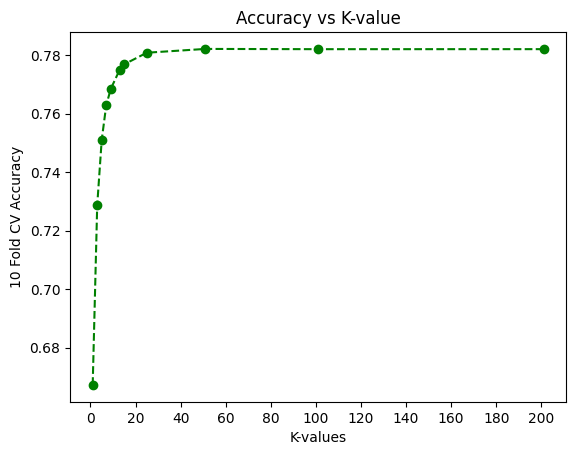

In [75]:
# As we can see from the plot, k=20 is a good compromise between model performance and training efficiency
plt.plot(ktry, accuracies_grouped, linestyle='--', marker='o', color="g")
plt.title("Accuracy vs K-value")
plt.xlabel("K-values")
plt.ylabel("10 Fold CV Accuracy")
plt.xticks(range(0, 201, 20))
plt.show()

10 Fold CV: 0.779980671753731
Recall       0.781659
Precision    0.694222
F1           0.692666
Accuracy     0.781659
dtype: float64
High      0.991227
Medium    0.005504
Low       0.003269
dtype: float64


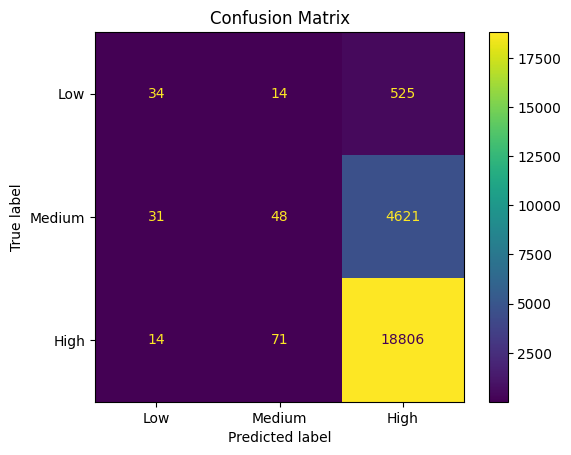

array([[   34,    14,   525],
       [   31,    48,  4621],
       [   14,    71, 18806]])

In [76]:
# model evaluation and validation data
model = train_knn(X_train, y_train_grouped, 20)
print(f"10 Fold CV: {k_cross_validate(model, Xdata, ydata_grouped)}")
print(eval_model(model, X_test, y_test_grouped))
print(get_baseline(model, X_test, y_test_grouped))

labels=['Low', 'Medium', 'High']
make_show_CM(model, X_test, y_test_grouped, labels)

For Exact KNN model

In [77]:
# testing different k sizes to determine best one
ktry = [1,3,5,7,9,13,15,25,51,101,201]
accuracies = []
for k in ktry:
    print(f"Now trying: {k}")
    model = train_knn(X_train, y_train, k)
    accuracies.append(k_cross_validate(model, Xdata, ydata))


Now trying: 1
Now trying: 3
Now trying: 5
Now trying: 7
Now trying: 9
Now trying: 13
Now trying: 15
Now trying: 25
Now trying: 51
Now trying: 101
Now trying: 201


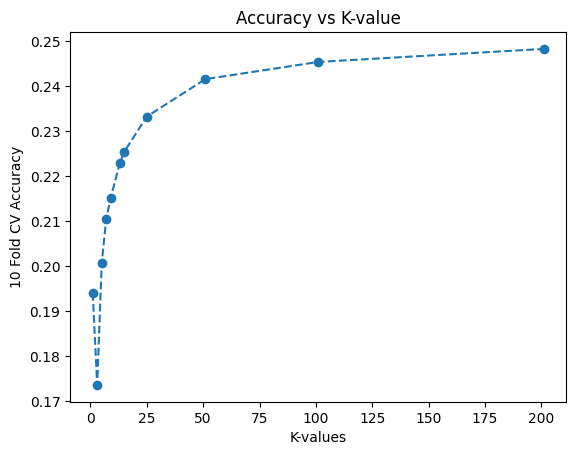

In [78]:
# As we can see from the plot, k=25 is a good compromise between model performance and training efficiency
plt.plot(ktry, accuracies, linestyle='--', marker='o')
plt.title("Accuracy vs K-value")
plt.xlabel("K-values")
plt.ylabel("10 Fold CV Accuracy")
plt.xticks(range(0, 201, 25), )
plt.show()

10 Fold CV: 0.2332536519524037


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall       0.233033
Precision    0.202963
F1           0.204651
Accuracy     0.233033
dtype: float64
8     0.461803
7     0.191690
10    0.177164
9     0.113475
5     0.036542
6     0.015767
1     0.003269
4     0.000290
dtype: float64


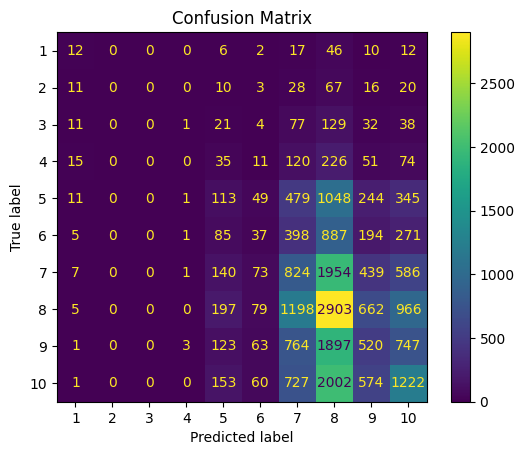

In [79]:
# model evaluation and validation data
model = train_knn(X_train, y_train, 25)
print(f"10 Fold CV: {k_cross_validate(model, Xdata, ydata)}")
print(eval_model(model, X_test, y_test))
print(get_baseline(model, X_test, y_test))

lbls = [1,2,3,4,5,6,7,8,9,10]
cm = make_show_CM(model, X_test, y_test, lbls)

#### Decision Tree

In [80]:
new_users = users.set_index("User-ID")

# for mapping cols of users to ratings
user_dict = new_users.to_dict()

usr_city = ratings["User-ID"].map(user_dict["User-City"])
usr_state = ratings["User-ID"].map(user_dict["User-State"])
usr_ctry = ratings["User-ID"].map(user_dict["User-Country"])
usr_age = ratings["User-ID"].map(user_dict["User-Age"])
usr_id = ratings["User-ID"] #quite 

usr_cols = [usr_city, usr_state, usr_ctry, usr_age, usr_id]
col_name = ["User-City", "User-State", "User-Country","User-Age", "User-ID"]

# comparing Users features to ratings
for i in range(len(usr_cols)):
    print(col_name[i], normalized_mutual_info_score(usr_cols[i], ratings["Book-Rating"], average_method='min'))

User-City 0.11247181967095064
User-State 0.014947789476197714
User-Country 0.006605477719809383
User-Age 0.0047351275919494925
User-ID 0.4175322224571087


In [81]:
new_users = users.set_index("User-ID")

# for mapping cols of users to ratings
user_dict = new_users.to_dict()

usr_city = ratings["User-ID"].map(user_dict["User-City"])
usr_state = ratings["User-ID"].map(user_dict["User-State"])
usr_ctry = ratings["User-ID"].map(user_dict["User-Country"])
usr_age = ratings["User-ID"].map(user_dict["User-Age"])
usr_id = ratings["User-ID"] #quite 

usr_cols = [usr_city, usr_state, usr_ctry, usr_age, usr_id]
col_name = ["User-City", "User-State", "User-Country","User-Age", "User-ID"]

# comparing Users features to ratings
for i in range(len(usr_cols)):
    print(col_name[i], normalized_mutual_info_score(usr_cols[i], ratings["Book-Rating"], average_method='min'))

# mapping for cols of BOOKS to ratings
bk_dict = books.set_index("ISBN").to_dict()

bk_isbn = ratings["ISBN"]
bk_title = ratings["ISBN"].map(bk_dict['Book-Title'])
bk_author = ratings["ISBN"].map(bk_dict['Book-Author'])
bk_yop = ratings["ISBN"].map(bk_dict['Year-Of-Publication'])
bk_publisher = ratings["ISBN"].map(bk_dict['Book-Publisher'])

bk_cols = [bk_isbn, bk_title, bk_author, bk_yop, bk_publisher]
col_name = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication','Book-Publisher']

# comparing book features to ratings
for i in range(len(bk_cols)):
    print(col_name[i], normalized_mutual_info_score(bk_cols[i], ratings["Book-Rating"], average_method='min'))

User-City 0.11247181967095064
User-State 0.014947789476197714
User-Country 0.006605477719809383
User-Age 0.0047351275919494925
User-ID 0.4175322224571087
ISBN 0.20645111097739202
Book-Title 0.18487315363403808
Book-Author 0.08964562855032683
Year-Of-Publication 0.0036007227653762214
Book-Publisher 0.026060282398355245


In [82]:
# encoding data
enc_usr_city, enc1 = encode(usr_city)
enc_usr_state, enc2 = encode(usr_state)
enc_usr_country, enc3 = encode(usr_ctry)

enc_bk_author, enc5 = encode(bk_author)
enc_bk_isbn, enc4 = encode(bk_isbn)
enc_bk_title, enc6 = encode(bk_title)
enc_bk_publisher, enc7 = encode(bk_publisher)

# Taking the four optimal columns
Xdata = pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher})
ydata = ratings["Book-Rating"].apply(categorise)

Accuracy: 0.77
Recall: 0.77
Precision: 0.69
F1: 0.70


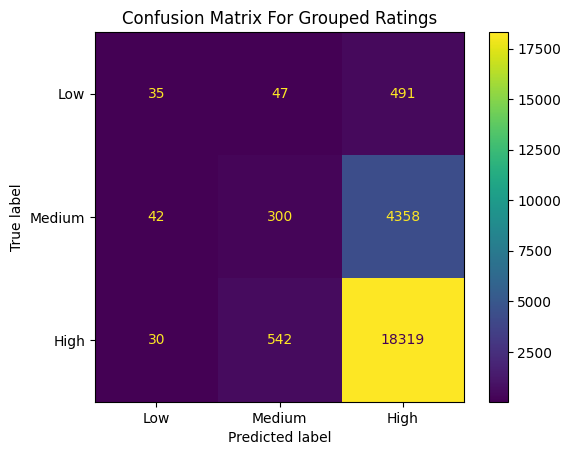

In [83]:
# Implementing DT model using binned ratings

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Using entropy to measure data uncertainty
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train_grouped)

# Predicting grouped ratings
y_pred = dt.predict(X_test)

# Outputting accuracy metrics
print("Accuracy:", '{:.2f}'.format(round(dt.score(X_test, y_test_grouped),2)))
print('Recall:', '{:.2f}'.format(round(recall_score(y_test_grouped, y_pred, average='weighted'),2)))
print('Precision:', '{:.2f}'.format(round(precision_score(y_test_grouped, y_pred, average='weighted'),2)))
print('F1:', '{:.2f}'.format(round(f1_score(y_test_grouped, y_pred,average='weighted'),2)))

cm = confusion_matrix(y_test_grouped, # test data
                      y_pred, # predictions
                      labels=['Low', 'Medium', 'High'] # class labels from the model
                     )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, # pass through the created confusion matrix
                              display_labels=['Low', 'Medium', 'High'] # class labels from the model 
                             )
disp.plot()
plt.title("Confusion Matrix For Grouped Ratings")
plt.show()

Accuracy 0.23
Recall: 0.23
Precision: 0.22
F1: 0.22


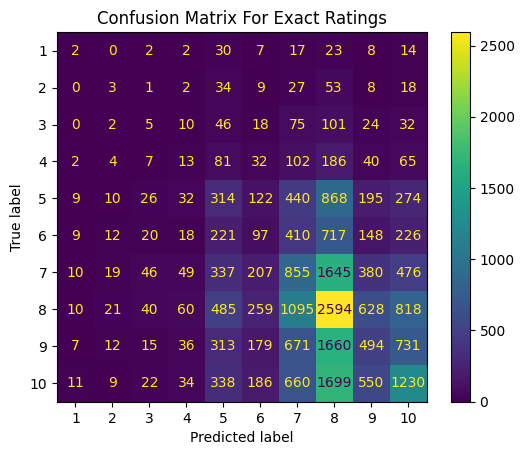

In [84]:
# Implementing DT model using exact ratings

# Using entropy to measure data uncertainty
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

# Predicting exact ratings
y_pred_exact = dt.predict(X_test)

# Outputting accuracy metrics
print("Accuracy", '{:.2f}'.format(round(dt.score(X_test, y_test),2)))
print('Recall:', '{:.2f}'.format(round(recall_score(y_test, y_pred_exact, average='weighted'),2)))
print('Precision:', '{:.2f}'.format(round(precision_score(y_test, y_pred_exact, average='weighted'),2)))
print('F1:', '{:.2f}'.format(round(f1_score(y_test, y_pred_exact,average='weighted'),2)))

cm = confusion_matrix(y_test, # test data
                      y_pred_exact, # predictions
                      labels=[1,2,3,4,5,6,7,8,9,10] # class labels from the model
                     )

disp = ConfusionMatrixDisplay(confusion_matrix=cm, # pass through the created confusion matrix
                              display_labels=[1,2,3,4,5,6,7,8,9,10] # class labels from the model 
                             )

disp.plot()
plt.title("Confusion Matrix For Exact Ratings")
plt.show()

[0.23126801152737753, 0.23126801152737753, 0.23126801152737753, 0.23126801152737753, 0.21229586935638808]


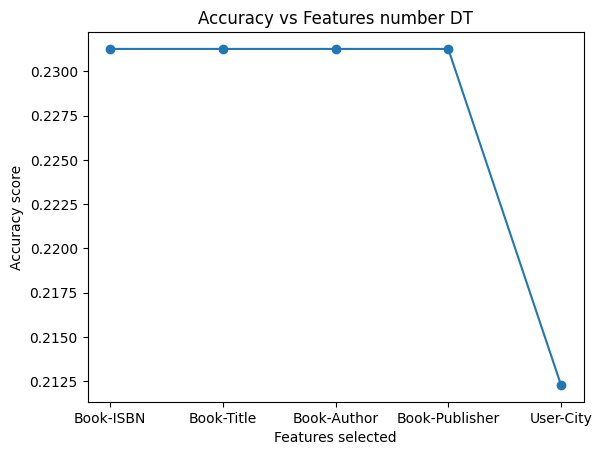

In [85]:
# Plotting that graph for feature analysis
y_train = ratings["Book-Rating"][:200000]
y_test = ratings["Book-Rating"][200000:]


feature_change= [
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-City": enc_usr_city}),    
]

TOP = ['Book-ISBN', 'Book-Title','Book-Author','Book-Publisher','User-City']
accuracies  = []

for i in range(len(feature_change)):
    Xdata = feature_change[i]
    X_train = Xdata[:200000]
    X_test = Xdata[200000:]

    ############################################
    # DT 
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    accuracy = dt.score(X_test, y_test)

    #########################################
    accuracies.append(accuracy)

print(accuracies)

plt.plot(TOP, accuracies, 'o-')
plt.xlabel('Features selected')
plt.ylabel('Accuracy score')
plt.title('Accuracy vs Features number DT')
plt.show()


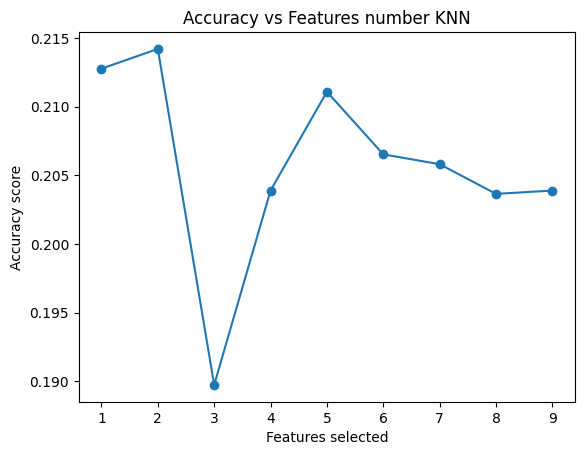

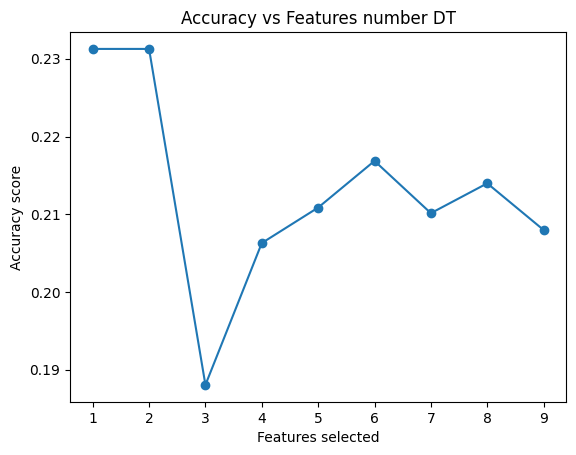

In [86]:
# another graph for feature analysis

feature_change= [
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-State": enc_usr_state}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-State": enc_usr_state, "User-Country": enc_usr_country}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-State": enc_usr_state, "User-Country": enc_usr_country, "User-Age": usr_age}),
    pd.DataFrame(data={"Book-ISBN": enc_bk_isbn, "Book-Title": enc_bk_title, "User-City": enc_usr_city, "Book-Author": enc_bk_author, "Book-Publisher": enc_bk_publisher, "User-State": enc_usr_state, "User-Country": enc_usr_country, "User-Age": usr_age, "Year-Of-Publication": bk_yop})
]

TOP = [1,2,3,4,5,6,7,8,9]
knn_accuracies  = []
dt_accuracies = []

for i in range(len(feature_change)):
    Xdata = feature_change[i]

    X_train = Xdata[:200000]
    X_test = Xdata[200000:]
    
    ############################################
    # Finding accuracy score using KNN k=5
    knn = KNeighborsClassifier(n_neighbors=5)
    # Fit to the train dataset
    knn.fit(X_train, y_train)
    
    # Note that we're calculating the accuracy score for the test data
    y_pred = knn.predict(X_test)
    knn_accuracies.append(knn.score(X_test, y_test))

    ############################################
    # Finding accuracy score using DT 
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    dt_accuracies.append(dt.score(X_test, y_test))
    ############################################

plt.plot(TOP, knn_accuracies, 'o-')
plt.xlabel('Features selected')
plt.ylabel('Accuracy score')
plt.title('Accuracy vs Features number KNN')
plt.show()

plt.plot(TOP, dt_accuracies, 'o-')
plt.xlabel('Features selected')
plt.ylabel('Accuracy score')
plt.title('Accuracy vs Features number DT')
plt.show()

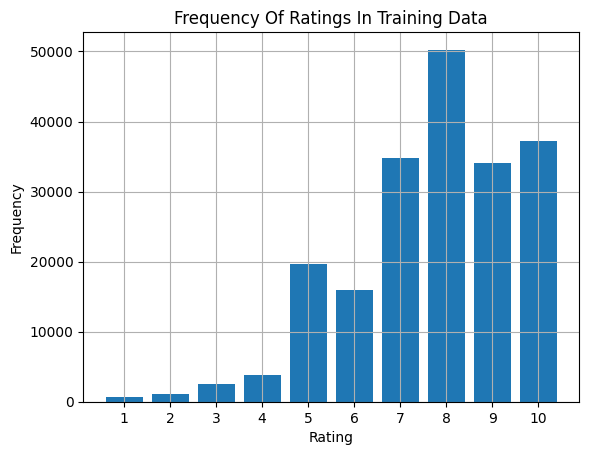

In [87]:
# graph for frequency of ratings

value_counts = y_train.value_counts().sort_index()

plt.bar(value_counts.index, value_counts.values)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency Of Ratings In Training Data')

plt.xticks(value_counts.index)
plt.grid(True)
plt.show()